In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

2024-06-14 06:42:49.725804: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 06:42:49.725857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 06:42:49.727348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
train_dir = '/kaggle/input/autism-vs-non-autism/Autis vs Non-autis/Train/train'
test_dir  = '/kaggle/input/autism-vs-non-autism/Autis vs Non-autis/Test/test'
val_dir = '/kaggle/input/autism-vs-non-autism/Autis vs Non-autis/Valid/valid'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=50,
        class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='binary'
)

Found 2526 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy is not None and val_accuracy is not None:
            if accuracy > 0.87 and val_accuracy > 0.8:
                self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/100


I0000 00:00:1718347383.944739     344 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 [==============================] - 45s 754ms/step - loss: 0.6490 - accuracy: 0.6722 - val_loss: 0.5452 - val_accuracy: 0.7400
Epoch 2/100
51/51 [==============================] - 37s 715ms/step - loss: 0.5308 - accuracy: 0.7284 - val_loss: 0.5196 - val_accuracy: 0.7700
Epoch 3/100
51/51 [==============================] - 37s 722ms/step - loss: 0.4937 - accuracy: 0.7656 - val_loss: 0.5081 - val_accuracy: 0.7950
Epoch 4/100
51/51 [==============================] - 37s 719ms/step - loss: 0.4868 - accuracy: 0.7716 - val_loss: 0.5090 - val_accuracy: 0.7500
Epoch 5/100
51/51 [==============================] - 37s 721ms/step - loss: 0.4802 - accuracy: 0.7633 - val_loss: 0.4803 - val_accuracy: 0.8200
Epoch 6/100
51/51 [==============================] - 37s 718ms/step - loss: 0.4666 - accuracy: 0.7795 - val_loss: 0.4693 - val_accuracy: 0.8200
Epoch 7/100
51/51 [==============================] - 37s 718ms/step - loss: 0.4405 - accuracy: 0.7926 - val_loss: 0.5047 - val_accuracy: 0.8050
Epoc

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

g_dict = train_generator.class_indices
classes = list(g_dict.keys())

preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

# Classification report
print(classification_report(test_generator.classes, y_pred, target_names= classes))

20/20 [==============================] - 1s 25ms/step
              precision    recall  f1-score   support

    autistic       0.50      1.00      0.67       100
non_autistic       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


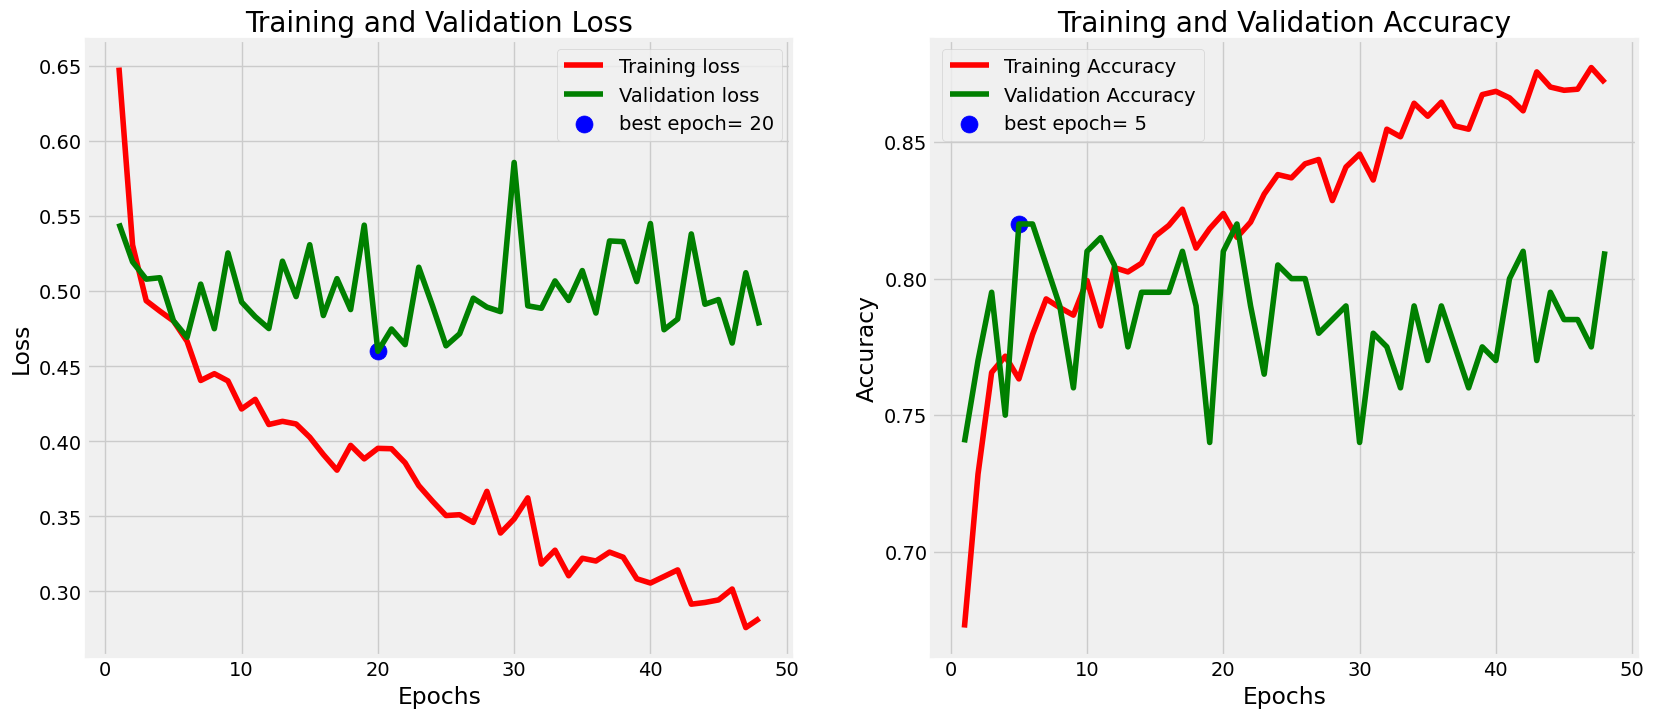

In [ ]:
# Define needed variables
def f_history(history = history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

f_history(history)

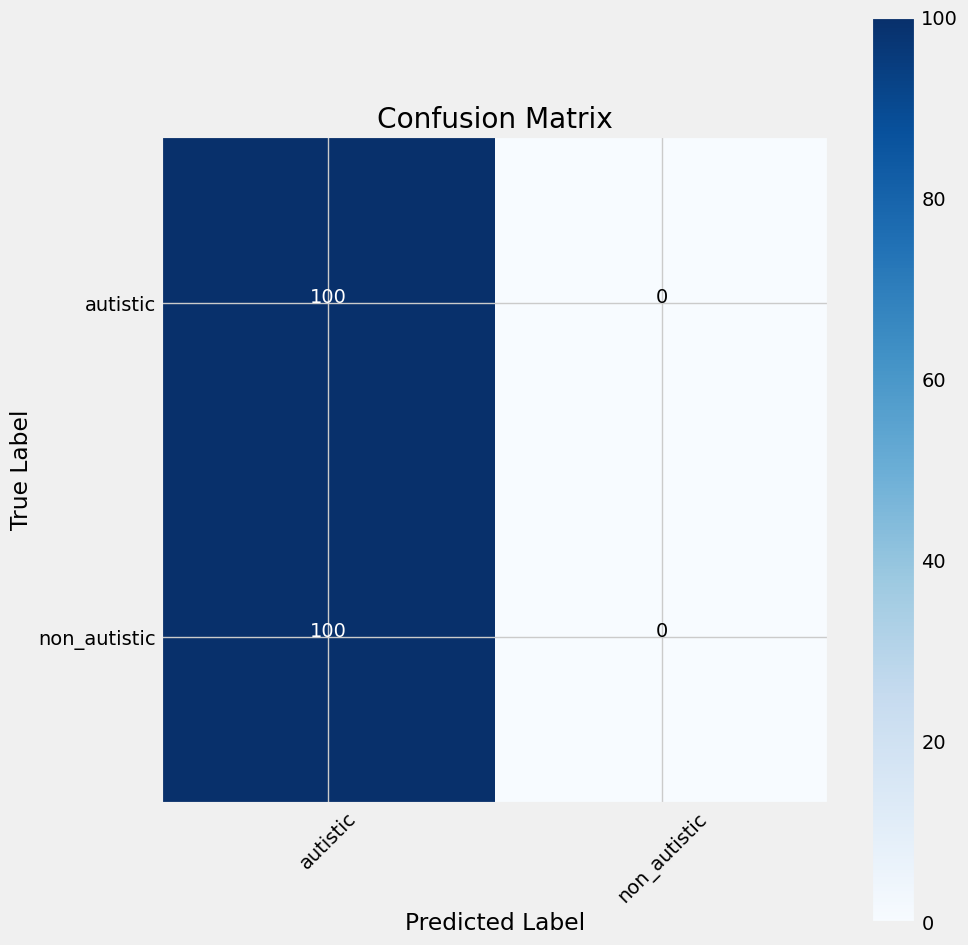

In [ ]:
import itertools
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

    # Confusion matrix
def f_cm(y_pred = y_pred):
    cm = confusion_matrix(test_generator.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

f_cm(y_pred)

In [ ]:
model.save('mobilenetv2_aziz.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step


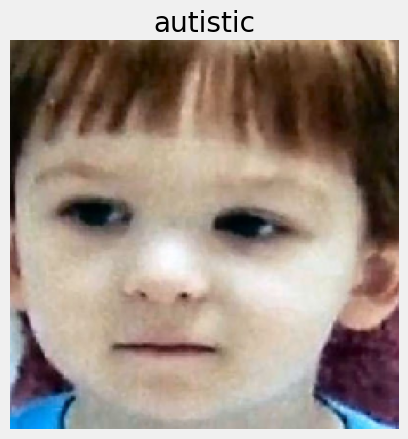

Predicted class: autistic


In [ ]:
model = tf.keras.models.load_model('/kaggle/working/mobilenetv2_aziz.h5')

image_path = ('/kaggle/input/autism-vs-non-autism/Autis vs Non-autis/Valid/valid/non_autistic/020.jpg')

image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)

predictions = model.predict(image_array)
predicted_class = (predictions[0] > 0.5).astype("int32")[0]
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class]

plt.imshow(image)
plt.title(predicted_class_label)
plt.axis('off')
plt.show()

print("Predicted class:", predicted_class_label)

In [ ]:
!pip install tensorflowjs --upgrade

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


INFO: pip is looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 63.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: tensorstore
    Found existing installation: tensorstore 0.1.60
    Uninstalling tensorstore-0.1.

In [ ]:
!tensorflowjs_converter --input_format keras /kaggle/working/mobilenetv2_aziz.h5 /kaggle/working/autism_tfjs_model

2024-06-14 07:15:48.123177: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 07:15:48.123245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 07:15:48.124758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
